In [16]:
! pip install optuna
!pip install "gymnasium[atari]"
!pip install "gymnasium[accept-rom-license]"
!pip install stable_baselines3


In [17]:
# Common imports
import numpy as np
import os
import optuna

In [18]:
os.mkdir("videosDDQN")
os.mkdir('logsDDQN')



In [19]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [20]:
##########  Using gym
import gymnasium as gym

# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
N_episodios = 49
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

from collections import deque

replay_memory = deque(maxlen=2000)

In [21]:
# Let's build the DQN.
# Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after
# it plays that action (but before it sees its outcome):
class DDQN():
    def __init__(self,batch_size= 32, discount_rate=0.5,loss_fn = keras.losses.mean_squared_error,learning_rate=1e-2):
        self.best_score = 0
        self.batch_size = batch_size
        self.discount_rate = discount_rate
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_fn = loss_fn



        self.model = keras.models.Sequential([
        keras.layers.Dense(32, activation="elu", input_shape=input_shape),
        keras.layers.Dense(256, activation="elu"),
        keras.layers.Dense(64, activation="elu"),
        keras.layers.Dense(32, activation="elu"),
        keras.layers.Flatten(),
        keras.layers.Dense(n_outputs)
    ])

        self.target = keras.models.clone_model(self.model)  # NEW It is a clone of the online model
        self.target.set_weights(self.model.get_weights())   # NEW

    def epsilon_greedy_policy(self,state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(n_outputs)
        else:
            Q_values = self.model.predict(state[np.newaxis])
            #print("Q_values", Q_values)
            return np.argmax(Q_values)

    def play_one_step(self,env, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        replay_memory.append((state, action, reward, next_state, done))
        return next_state, reward, done, info

    def sample_experiences(self,batch_size):
        indices = np.random.randint(len(replay_memory), size=batch_size)
        batch = [replay_memory[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        return states, actions, rewards, next_states, dones

    def training_step(self,batch_size):

        experiences = self.sample_experiences(batch_size)
        states, actions, rewards, next_states, dones = experiences
        #next_Q_values = model.predict(next_states)  # ORIGINAL DQN
        next_Q_values = self.target.predict(next_states)  # NEW  Using the target model instead the online model
        max_next_Q_values = np.max(next_Q_values, axis=1)
        target_Q_values = (rewards +
                        (1 - dones) * self.discount_rate * max_next_Q_values)
        target_Q_values = target_Q_values.reshape(-1, 1)
        mask = tf.one_hot(actions, n_outputs)
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)   # Use of the online model
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    def predict(self,obs):
        return self.model.predict(obs)
    def train(self):
        self.rewards = []

        for episode in range(N_episodios):
            obs = env.reset()
            obs = obs[0]
            print("Se resetea")
            for step in range(200):
                epsilon = max(1 - episode / 500, 0.01)
                obs, reward, done, info = self.play_one_step(env, obs, epsilon)
                if done:
                    break
            self.rewards.append(step) # Not shown in the book
            if step >= self.best_score: # Not shown
                best_weights = self.model.get_weights() # Not shown
                self.best_score = step # Not shown
            print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
            #print(" Episodio vvvv", episode)
            if episode > 50:
                #print(" batch size vvvv", batch_size)
                self.training_step(self.batch_size)
            if episode % 50 == 0:     ## Updating weights
                self.target.set_weights(self.model.get_weights())

        self.model.set_weights(best_weights)

log_dir = '/logsDDQN'

env = gym.make("ALE/AirRaid-v5",render_mode="rgb_array")
env = Monitor(env, log_dir)

input_shape =env.observation_space.shape
n_outputs = env.action_space.n



In [22]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [23]:
def objective(trial):
    # Define los rangos para los parámetros que quieres optimizar
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    discount_rate = trial.suggest_uniform('discount_rate', 0.1, 0.90)

    ddqn =DDQN(batch_size=batch_size,discount_rate=discount_rate,learning_rate=learning_rate)
    ddqn.train()
    # Define el callback para guardar el mejor modelo
    callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
    return ddqn.best_score

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)

print("Params: ")

[I 2024-05-08 17:07:28,252] A new study created in memory with name: no-name-2a75e98c-ed6d-43cc-9f6a-61725f1a1a4d
<ipython-input-23-f35024535739>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-23-f35024535739>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  discount_rate = trial.suggest_uniform('discount_rate', 0.1, 0.90)


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 149ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 27ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 40ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 48ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 39ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 48ms/step
Episode: 10, Steps

[I 2024-05-08 17:08:21,816] Trial 0 finished with value: 199.0 and parameters: {'learning_rate': 0.0006764742495084462, 'batch_size': 16, 'discount_rate': 0.5710467371476158}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 143ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 11, Steps: 200, eps: 0.978Se resetea
1/1 [=========================

[I 2024-05-08 17:09:04,300] Trial 1 finished with value: 199.0 and parameters: {'learning_rate': 0.0007450244867218142, 'batch_size': 32, 'discount_rate': 0.3398371721459489}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 140ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 19ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 11, Steps: 200, eps: 0.978Se res

[I 2024-05-08 17:09:47,416] Trial 2 finished with value: 199.0 and parameters: {'learning_rate': 0.000728684305300587, 'batch_size': 16, 'discount_rate': 0.657586004120488}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 203ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 44ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 32ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 35ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 11, Steps: 200, eps: 0.978Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 12, Steps: 200, eps: 

[I 2024-05-08 17:10:32,768] Trial 3 finished with value: 199.0 and parameters: {'learning_rate': 2.3248387549455084e-05, 'batch_size': 64, 'discount_rate': 0.5181739342135444}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 166ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 6, Steps: 171, eps: 0.988Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 11, Steps: 200,

[I 2024-05-08 17:11:12,790] Trial 4 finished with value: 199.0 and parameters: {'learning_rate': 0.0006387693308667632, 'batch_size': 64, 'discount_rate': 0.632851282397881}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================]

[I 2024-05-08 17:11:56,348] Trial 5 finished with value: 199.0 and parameters: {'learning_rate': 0.00020124368008363406, 'batch_size': 16, 'discount_rate': 0.5955142654632674}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 29ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 30ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 30ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 28ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 34ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 33ms/step
Episode: 10, Steps: 200, eps: 0.980S

[I 2024-05-08 17:12:38,634] Trial 6 finished with value: 199.0 and parameters: {'learning_rate': 3.666470432302711e-05, 'batch_size': 64, 'discount_rate': 0.7951548045014657}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 172, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 26ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 11, Steps: 200, eps: 0.978Se rese

[I 2024-05-08 17:13:22,295] Trial 7 finished with value: 199.0 and parameters: {'learning_rate': 0.0005398839497391314, 'batch_size': 32, 'discount_rate': 0.38600101292856026}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 168, eps: 0.998Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 10, Steps: 200, eps: 0.980S

[I 2024-05-08 17:14:07,800] Trial 8 finished with value: 199.0 and parameters: {'learning_rate': 5.1195180855075484e-05, 'batch_size': 16, 'discount_rate': 0.217119694932172}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 216ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 31ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 38ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 29ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 32ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 25ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 11, Steps: 200,

[I 2024-05-08 17:14:55,453] Trial 9 finished with value: 199.0 and parameters: {'learning_rate': 1.0990426870981513e-05, 'batch_size': 16, 'discount_rate': 0.3891563088814102}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 149ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 25ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 11, Steps: 200, eps: 0.978Se resetea
1/1 [==============================] - 0s 25ms/step
Episode: 12, Steps: 200, eps: 

[I 2024-05-08 17:15:42,755] Trial 10 finished with value: 199.0 and parameters: {'learning_rate': 0.0001980818930736383, 'batch_size': 128, 'discount_rate': 0.8678751673163703}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 144ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 27ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 11, Steps: 200,

[I 2024-05-08 17:16:29,672] Trial 11 finished with value: 199.0 and parameters: {'learning_rate': 0.00027807154693969873, 'batch_size': 32, 'discount_rate': 0.1099328554495175}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 147ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 26ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 25ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 32ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 100ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0

[I 2024-05-08 17:17:17,905] Trial 12 finished with value: 199.0 and parameters: {'learning_rate': 0.0003267102887292342, 'batch_size': 32, 'discount_rate': 0.35419719985250064}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 154ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 6, Steps: 196, eps: 0.988Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 10, Steps: 200, eps: 0.980

[I 2024-05-08 17:18:03,051] Trial 13 finished with value: 199.0 and parameters: {'learning_rate': 0.00010038897611988885, 'batch_size': 128, 'discount_rate': 0.4718208253729689}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 139ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 34ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 30ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 35ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 29ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 32ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 44ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 11, Steps: 200,

[I 2024-05-08 17:18:54,324] Trial 14 finished with value: 199.0 and parameters: {'learning_rate': 0.0008444230141779134, 'batch_size': 32, 'discount_rate': 0.2578883082288066}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 171ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 6, Steps: 195, eps: 0.988Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 31ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 42ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 32ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s

[I 2024-05-08 17:19:40,637] Trial 15 finished with value: 199.0 and parameters: {'learning_rate': 0.00010529392497185097, 'batch_size': 16, 'discount_rate': 0.7260706320673993}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 144ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 26ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 11, Steps: 200, eps: 0.978Se res

[I 2024-05-08 17:20:28,215] Trial 16 finished with value: 199.0 and parameters: {'learning_rate': 0.000402226884065358, 'batch_size': 32, 'discount_rate': 0.5020294122959396}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 193ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 31ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 33ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 44ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 34ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 32ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [===================

[I 2024-05-08 17:21:14,840] Trial 17 finished with value: 199.0 and parameters: {'learning_rate': 0.0009991538561253978, 'batch_size': 128, 'discount_rate': 0.29693836575885796}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 10, Steps:

[I 2024-05-08 17:22:00,975] Trial 18 finished with value: 199.0 and parameters: {'learning_rate': 0.00023072618740831012, 'batch_size': 32, 'discount_rate': 0.16805197757621798}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 211ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 31ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 29ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 30ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 31ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 41ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 10, Steps

[I 2024-05-08 17:22:49,448] Trial 19 finished with value: 199.0 and parameters: {'learning_rate': 0.0004597599518732193, 'batch_size': 16, 'discount_rate': 0.5531375240004955}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 31ms/step
Episode: 11, Steps: 200, 

[I 2024-05-08 17:23:34,428] Trial 20 finished with value: 199.0 and parameters: {'learning_rate': 0.00012710681752926066, 'batch_size': 16, 'discount_rate': 0.44109158046516384}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 287ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 34ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [===================

[I 2024-05-08 17:24:23,679] Trial 21 finished with value: 199.0 and parameters: {'learning_rate': 0.0006710046168944939, 'batch_size': 16, 'discount_rate': 0.6689715603577249}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 31ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 29ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 35ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 33ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 

[I 2024-05-08 17:25:10,343] Trial 22 finished with value: 199.0 and parameters: {'learning_rate': 0.000980730514873702, 'batch_size': 16, 'discount_rate': 0.7101030955213309}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 25ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 

[I 2024-05-08 17:25:58,244] Trial 23 finished with value: 199.0 and parameters: {'learning_rate': 0.00046227565750667774, 'batch_size': 16, 'discount_rate': 0.5662737062299386}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 230ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 37ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 50ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s

[I 2024-05-08 17:26:45,145] Trial 24 finished with value: 199.0 and parameters: {'learning_rate': 0.0006775149307588858, 'batch_size': 16, 'discount_rate': 0.7777290513476899}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 141ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 25ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 10, Steps

[I 2024-05-08 17:27:33,327] Trial 25 finished with value: 199.0 and parameters: {'learning_rate': 0.0003531139329059518, 'batch_size': 32, 'discount_rate': 0.32241318697759125}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 25ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
Episode: 11, Steps: 200, eps: 0.978Se resetea
1/1 [==========================

[I 2024-05-08 17:28:18,055] Trial 26 finished with value: 199.0 and parameters: {'learning_rate': 0.0006941440994067016, 'batch_size': 64, 'discount_rate': 0.43894439782330236}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 162ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [===================

[I 2024-05-08 17:29:08,371] Trial 27 finished with value: 199.0 and parameters: {'learning_rate': 6.401938188132607e-05, 'batch_size': 128, 'discount_rate': 0.6277040479398853}. Best is trial 0 with value: 199.0.


Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 143ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 23ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 27ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 20ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 11, Steps: 200,

[I 2024-05-08 17:29:55,986] Trial 28 finished with value: 199.0 and parameters: {'learning_rate': 0.00015492737376322912, 'batch_size': 16, 'discount_rate': 0.8701011124311316}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
1/1 [==============================] - 0s 158ms/step
Episode: 1, Steps: 200, eps: 0.998Se resetea
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 33ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 36ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
1/1 [==============================] - 0s 31ms/step
Episode: 5, Steps: 200, eps: 0.990Se resetea
1/1 [==============================] - 0s 31ms/step
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 32ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
1/1 [==============================] - 0s 35ms/step
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 22ms/step
Episode: 10, Steps: 200, eps: 0.980

[I 2024-05-08 17:30:44,932] Trial 29 finished with value: 199.0 and parameters: {'learning_rate': 1.1281082571094176e-05, 'batch_size': 64, 'discount_rate': 0.6710864713637251}. Best is trial 0 with value: 199.0.


Episode: 48, Steps: 200, eps: 0.904Best trial:
Value:  199.0
Params: 


Con el mejor intento, lo entreno y saco los rewards

Se resetea
Episode: 0, Steps: 200, eps: 1.000Se resetea
Episode: 1, Steps: 200, eps: 0.998Se resetea
1/1 [==============================] - 0s 255ms/step
Episode: 2, Steps: 200, eps: 0.996Se resetea
1/1 [==============================] - 0s 24ms/step
Episode: 3, Steps: 200, eps: 0.994Se resetea
1/1 [==============================] - 0s 26ms/step
Episode: 4, Steps: 200, eps: 0.992Se resetea
Episode: 5, Steps: 200, eps: 0.990Se resetea
Episode: 6, Steps: 200, eps: 0.988Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 7, Steps: 200, eps: 0.986Se resetea
Episode: 8, Steps: 200, eps: 0.984Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 9, Steps: 200, eps: 0.982Se resetea
1/1 [==============================] - 0s 21ms/step
Episode: 10, Steps: 200, eps: 0.980Se resetea
1/1 [==============================] - 0s 33ms/step
Episode: 11, Steps: 200, eps: 0.978Se resetea
1/1 [==============================] - 0s 34ms/step
Episode: 12, Steps: 200, eps: 

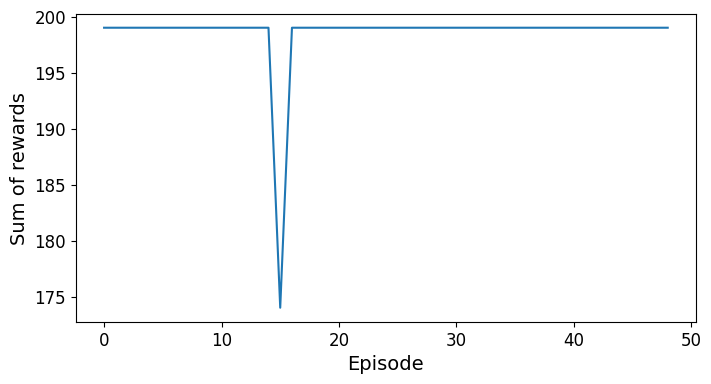

In [25]:
ddqn =DDQN(batch_size=trial.params['batch_size'],discount_rate=trial.params['discount_rate'],learning_rate=trial.params['learning_rate'])
ddqn.train()
plt.figure(figsize=(8, 4))
plt.plot(ddqn.rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [26]:
# Now show the animation:

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [29]:

from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

env_id = "ALE/AirRaid-v5"
directorio_video = 'videosDDQN'

longitud = 1819

vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])

obs = vec_env.reset()

# Record the video starting at the first step
vec_env = VecVideoRecorder(vec_env, directorio_video,
                       record_video_trigger=lambda x: x == 0, video_length=longitud,
                       name_prefix=f"agent")
vec_env.reset()
for _ in range(longitud + 1):
  action = np.argmax(ddqn.predict(obs),axis = 1)
  obs, _, _, _ = vec_env.step(action)
# Save the video
vec_env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


1/1 [==============================] - 0s 20ms/step
Saving video to /content/videosDDQN/agent-step-0-to-step-1819.mp4
Moviepy - Building video /content/videosDDQN/agent-step-0-to-step-1819.mp4.
Moviepy - Writing video /content/videosDDQN/agent-step-0-to-step-1819.mp4



Moviepy - Done !
Moviepy - video ready /content/videosDDQN/agent-step-0-to-step-1819.mp4
1/1 [==============================] - 0s 40ms/step
